### **Dataset Link: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews**

## **Apply Word2Vec**

You can also apply TF-IDF in the same way

In [ ]:
# If you use google colab then at first install this packages

!pip install --upgrade contractions

!pip install --upgrade tqdm

!pip install --upgrade gensim

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score,confusion_matrix

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer

import gensim
from gensim.utils import simple_preprocess

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import contractions

from tqdm import tqdm

### Load the dataset

Here, I just take 10,000 or 20% data from the enitre dataset.
The reason of this, if I take full dataset then it will take much more time to train and preprocessing of the data. So, I just take 50% data for train model quickly.

In [2]:
all_data = pd.read_csv("/content/drive/MyDrive/Machine Learning/NLP/Project/Movie Sentiment Analysis/datasets/IMDB Dataset.csv")

In [3]:
df = all_data.iloc[:10000].copy()

In [4]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## **Do some EDA**

In [5]:
df.shape

(10000, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  object
dtypes: object(2)
memory usage: 156.4+ KB


In [7]:
# Check null values

df.isna().sum()

review       0
sentiment    0
dtype: int64

In [8]:
# number of positive and negative class
df['sentiment'].value_counts()

positive    5028
negative    4972
Name: sentiment, dtype: int64

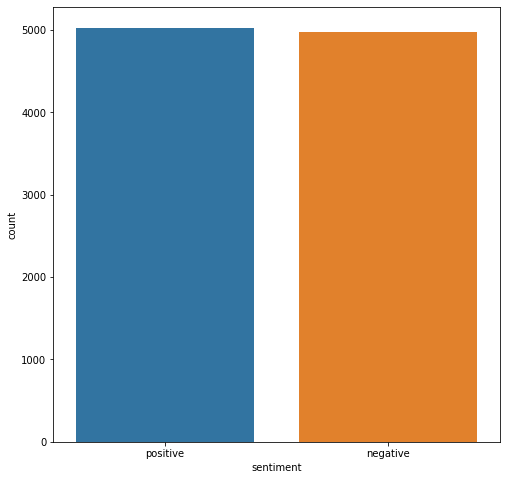

In [9]:
# See the dataset is balance or not

plt.figure(figsize=(8,8))
sns.countplot(x='sentiment', data=df)
plt.show()

In [10]:
# Check the duplicated rows exists or not

df.duplicated().sum()

17

In [11]:
# Drop the duplicate rows

df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [12]:
# Now check the shape

df.shape

(9983, 2)

In [13]:
# Now check the duplicate rows

df.duplicated().sum()

0

## **Apply Text preprocessing**

In [14]:
df.loc[0, 'review']

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

In [15]:
df.loc[5, 'review']

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

In [16]:
df.loc[4000, 'review']

'"Just before dawn " is one of the best slasher films.It very realistic and atmospheric.It reminds me Tobe Hooper`s "The Texas chainsaw massacre " and "Deliverance ".Deborah Benson very good plays the heroine and director Jeff Lieberman created very creepy and dark movie."Just before dawn " is beautiful photographed and soundtrack is very disturbing.I never<br /><br />liked slasher films or gore except with this one.Very impressive and convincing movie ( at least for me )'

In [17]:
# Demo test
x = "alaminbhuyan321@gmail.com!!!"

print(x.translate(str.maketrans('', '', string.punctuation)))
print(type(x.translate(str.maketrans('', '', string.punctuation))))

# Demo test end

alaminbhuyan321gmailcom
<class 'str'>


### **Handeling contractions words**

In [18]:
# Demo test

print(contractions.fix(s="I'm a student"))

contractions.add(key="Iam", value="I am")

print(contractions.fix(s="yall"))
print(contractions.fix(s="Iam"))

# Demo test end

I am a student
you all
I Am


In [19]:
# Handeling contractions words

def expand_contractions_words(text):
    text = contractions.fix(s=text)
    return text

In [20]:
# Demo test

expand_contractions_words("""i thought this movie was really really great! \
Helena did an amazing job in it! I thought she played her character very well! \
she's an AWESOME actress!! :)<br /><br />the movie was also really funny too! \
The jokes were great! i couldnt stop laughing! :)<br /><br />i think everyone should see it... :)<br /><br />""")

# Demo test end

'i thought this movie was really really great! Helena did an amazing job in it! I thought she played her character very well! she is an AWESOME actress!! :)<br /><br />the movie was also really funny too! The jokes were great! i could not stop laughing! :)<br /><br />i think everyone should see it... :)<br /><br />'

In [21]:
df['review'] = df['review'].apply(func=expand_contractions_words)

In [22]:
df.loc[0, 'review']

'One of the other reviewers has mentioned that after watching just 1 Oz episode you will be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Them City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to th

In [23]:
# Remove HTML tags, punctuation, space, and digits

def clean_text(text):
    # make text lower case
    text = text.lower()
    # remove html tags
    text = re.sub(pattern=r"<.*?>", repl="", string=text)
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # remove digits
    text = re.sub(pattern=r"\d+", repl=" ", string=text)
    # remove white space
    text = " ".join(text.split())

    return text

In [24]:
df['review'] = df['review'].apply(func=clean_text)

In [25]:
df.loc[0, 'review']

'one of the other reviewers has mentioned that after watching just oz episode you will be hooked they are right as this is exactly what happened with methe first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordit is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda them city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayi would say the main appeal of the show is due to the fact that it goes where other shows would not dare forget pretty p

In [26]:
df.loc[5000, 'review']

'transylvania is an insignificant but occasionally funny and charming mid s horror parody with some very familiar names in the cast and a handful of genuine opportunities to chuckle in the script two bozo journalist of a gossipy tabloid newspaper are sent very much against their will to transylvania to do a story on the alleged return of mad scientist frankenstein there are some adorable little gimmicks and details to discover left and right in the film like a little guillotine for hardboiled eggs and laboratory test tubes that are being used to put in cream and sugar at the breakfast table the wholesome of the film however is not as successful as it could and should have been with jokes and parody situations that are way too overlong the roger corman production transylvania twist which came out four years after this is a lot funnier and much more recommended the film is particularly parodying the classic universal milestones of the early s so you better make sure you have seen those i

In [27]:
# If you use google colab then use this line
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [28]:
# Remove stopwords and apply stemming
ps = PorterStemmer()

def clean_text2(text):
    words = word_tokenize(text=text)
    words = [ps.stem(word=word) for word in words if word not in stopwords.words("english")]
    text = " ".join(words)

    return text

In [29]:
# demo test 

clean_text2("""i thought this movie was really really great helena did an amazing job in it i \
thought she played her character very well she is an awesome actress \
the movie was also really funny too the jokes were great i could not stop laughing i think everyone should see it""")

# demo test end

'thought movi realli realli great helena amaz job thought play charact well awesom actress movi also realli funni joke great could stop laugh think everyon see'

In [30]:
# Apply on review column for entire dataset

df['review'] = df['review'].apply(func=clean_text2)

In [31]:
df.loc[1, 'review']

'wonder littl product film techniqu unassum oldtimebbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrificli written perform piec master product one great master comedi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particularli scene concern orton halliwel set particularli flat halliwel mural decor everi surfac terribl well done'

In [32]:
sent_tokenize(text=df.loc[1, 'review'])

['wonder littl product film techniqu unassum oldtimebbc fashion give comfort sometim discomfort sens realism entir piec actor extrem well chosen michael sheen got polari voic pat truli see seamless edit guid refer william diari entri well worth watch terrificli written perform piec master product one great master comedi life realism realli come home littl thing fantasi guard rather use tradit dream techniqu remain solid disappear play knowledg sens particularli scene concern orton halliwel set particularli flat halliwel mural decor everi surfac terribl well done']

In [33]:
word_tokenize(text=df.loc[1, 'review'])

['wonder',
 'littl',
 'product',
 'film',
 'techniqu',
 'unassum',
 'oldtimebbc',
 'fashion',
 'give',
 'comfort',
 'sometim',
 'discomfort',
 'sens',
 'realism',
 'entir',
 'piec',
 'actor',
 'extrem',
 'well',
 'chosen',
 'michael',
 'sheen',
 'got',
 'polari',
 'voic',
 'pat',
 'truli',
 'see',
 'seamless',
 'edit',
 'guid',
 'refer',
 'william',
 'diari',
 'entri',
 'well',
 'worth',
 'watch',
 'terrificli',
 'written',
 'perform',
 'piec',
 'master',
 'product',
 'one',
 'great',
 'master',
 'comedi',
 'life',
 'realism',
 'realli',
 'come',
 'home',
 'littl',
 'thing',
 'fantasi',
 'guard',
 'rather',
 'use',
 'tradit',
 'dream',
 'techniqu',
 'remain',
 'solid',
 'disappear',
 'play',
 'knowledg',
 'sens',
 'particularli',
 'scene',
 'concern',
 'orton',
 'halliwel',
 'set',
 'particularli',
 'flat',
 'halliwel',
 'mural',
 'decor',
 'everi',
 'surfac',
 'terribl',
 'well',
 'done']

In [34]:
simple_preprocess(doc=df.loc[1, 'review'])

['wonder',
 'littl',
 'product',
 'film',
 'techniqu',
 'unassum',
 'oldtimebbc',
 'fashion',
 'give',
 'comfort',
 'sometim',
 'discomfort',
 'sens',
 'realism',
 'entir',
 'piec',
 'actor',
 'extrem',
 'well',
 'chosen',
 'michael',
 'sheen',
 'got',
 'polari',
 'voic',
 'pat',
 'truli',
 'see',
 'seamless',
 'edit',
 'guid',
 'refer',
 'william',
 'diari',
 'entri',
 'well',
 'worth',
 'watch',
 'terrificli',
 'written',
 'perform',
 'piec',
 'master',
 'product',
 'one',
 'great',
 'master',
 'comedi',
 'life',
 'realism',
 'realli',
 'come',
 'home',
 'littl',
 'thing',
 'fantasi',
 'guard',
 'rather',
 'use',
 'tradit',
 'dream',
 'techniqu',
 'remain',
 'solid',
 'disappear',
 'play',
 'knowledg',
 'sens',
 'particularli',
 'scene',
 'concern',
 'orton',
 'halliwel',
 'set',
 'particularli',
 'flat',
 'halliwel',
 'mural',
 'decor',
 'everi',
 'surfac',
 'terribl',
 'well',
 'done']

In [35]:
story = []

for doc in df['review']:
    raw_sentence = sent_tokenize(text=doc)
    for sentence in raw_sentence:
        story.append(simple_preprocess(doc=sentence))

In [36]:
len(story)

9983

In [37]:
# I just show the 50 rows
story[:50]

[['one',
  'review',
  'mention',
  'watch',
  'oz',
  'episod',
  'hook',
  'right',
  'exactli',
  'happen',
  'meth',
  'first',
  'thing',
  'struck',
  'oz',
  'brutal',
  'unflinch',
  'scene',
  'violenc',
  'set',
  'right',
  'word',
  'go',
  'trust',
  'show',
  'faint',
  'heart',
  'timid',
  'show',
  'pull',
  'punch',
  'regard',
  'drug',
  'sex',
  'violenc',
  'hardcor',
  'classic',
  'use',
  'wordit',
  'call',
  'oz',
  'nicknam',
  'given',
  'oswald',
  'maximum',
  'secur',
  'state',
  'penitentari',
  'focus',
  'mainli',
  'emerald',
  'citi',
  'experiment',
  'section',
  'prison',
  'cell',
  'glass',
  'front',
  'face',
  'inward',
  'privaci',
  'high',
  'agenda',
  'citi',
  'home',
  'manyaryan',
  'muslim',
  'gangsta',
  'latino',
  'christian',
  'italian',
  'irish',
  'moreso',
  'scuffl',
  'death',
  'stare',
  'dodgi',
  'deal',
  'shadi',
  'agreement',
  'never',
  'far',
  'awayi',
  'would',
  'say',
  'main',
  'appeal',
  'show',
  'd

## **Let's create our model**

In [38]:
model = gensim.models.Word2Vec(window=10, min_count=2)

In [39]:
model.build_vocab(corpus_iterable=story)

In [40]:
print(model.corpus_count) # total corpus length
print(model.epochs)

9983
5


In [41]:
# total_examples means how many sentences have in our entire corpus

model.train(corpus_iterable=story, total_examples=model.corpus_count, epochs=model.epochs)

(5287581, 5790340)

In [42]:
# Demo test

model.wv.most_similar("kill")

# Demo test end

[('dead', 0.8829342722892761),
 ('killer', 0.8829320073127747),
 ('blah', 0.8402197957038879),
 ('walk', 0.8352261185646057),
 ('bed', 0.8346325755119324),
 ('rape', 0.834287703037262),
 ('die', 0.8338414430618286),
 ('kayako', 0.8311131596565247),
 ('zodiac', 0.8269907236099243),
 ('goe', 0.8261668682098389)]

In [43]:
model.wv.get_normed_vectors().shape

# here 24749 is our unique word that we have used in our vocab and
# 100 means 100 dimension vector representation of each word

(24749, 100)

In [44]:
model.wv.vector_size

100

In [45]:
len(model.wv.key_to_index)

24749

In [46]:
model.wv.key_to_index

{'movi': 0,
 'film': 1,
 'one': 2,
 'like': 3,
 'would': 4,
 'time': 5,
 'good': 6,
 'make': 7,
 'get': 8,
 'charact': 9,
 'see': 10,
 'watch': 11,
 'even': 12,
 'stori': 13,
 'realli': 14,
 'scene': 15,
 'show': 16,
 'look': 17,
 'well': 18,
 'much': 19,
 'go': 20,
 'great': 21,
 'could': 22,
 'peopl': 23,
 'bad': 24,
 'love': 25,
 'end': 26,
 'play': 27,
 'think': 28,
 'first': 29,
 'also': 30,
 'act': 31,
 'way': 32,
 'thing': 33,
 'made': 34,
 'say': 35,
 'know': 36,
 'seem': 37,
 'come': 38,
 'work': 39,
 'never': 40,
 'littl': 41,
 'want': 42,
 'mani': 43,
 'actor': 44,
 'plot': 45,
 'take': 46,
 'seen': 47,
 'two': 48,
 'year': 49,
 'best': 50,
 'tri': 51,
 'life': 52,
 'ever': 53,
 'give': 54,
 'better': 55,
 'still': 56,
 'perform': 57,
 'man': 58,
 'feel': 59,
 'use': 60,
 'someth': 61,
 'actual': 62,
 'find': 63,
 'lot': 64,
 'part': 65,
 'real': 66,
 'director': 67,
 'interest': 68,
 'us': 69,
 'back': 70,
 'guy': 71,
 'though': 72,
 'noth': 73,
 'music': 74,
 'funni': 75,


In [47]:
model.wv.index_to_key

['movi',
 'film',
 'one',
 'like',
 'would',
 'time',
 'good',
 'make',
 'get',
 'charact',
 'see',
 'watch',
 'even',
 'stori',
 'realli',
 'scene',
 'show',
 'look',
 'well',
 'much',
 'go',
 'great',
 'could',
 'peopl',
 'bad',
 'love',
 'end',
 'play',
 'think',
 'first',
 'also',
 'act',
 'way',
 'thing',
 'made',
 'say',
 'know',
 'seem',
 'come',
 'work',
 'never',
 'littl',
 'want',
 'mani',
 'actor',
 'plot',
 'take',
 'seen',
 'two',
 'year',
 'best',
 'tri',
 'life',
 'ever',
 'give',
 'better',
 'still',
 'perform',
 'man',
 'feel',
 'use',
 'someth',
 'actual',
 'find',
 'lot',
 'part',
 'real',
 'director',
 'interest',
 'us',
 'back',
 'guy',
 'though',
 'noth',
 'music',
 'funni',
 'cast',
 'live',
 'new',
 'star',
 'enjoy',
 'everi',
 'set',
 'old',
 'point',
 'role',
 'anoth',
 'start',
 'origin',
 'girl',
 'turn',
 'pretti',
 'kill',
 'believ',
 'day',
 'wonder',
 'direct',
 'quit',
 'minut',
 'got',
 'effect',
 'around',
 'world',
 'young',
 'fact',
 'thought',
 'ho

In [51]:
# Demo test

df['review'].values[0]

'one review mention watch oz episod hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show would dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz mess around first episod ever saw struck nasti surreal could say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort viewingthat get t

In [52]:
# 100 dimension of Vector representation of kill word

model.wv['kill']

array([ 2.00752401e+00,  1.17462945e+00, -2.45016241e+00, -9.47287023e-01,
        3.46728235e-01, -9.39183950e-01,  4.38486099e-01,  4.56649840e-01,
        9.10597146e-01,  1.73042977e+00, -6.42908588e-02, -5.64402521e-01,
       -1.43682194e+00, -3.38690013e-01,  1.42127717e+00, -8.35234284e-01,
       -1.88362554e-01, -4.04696584e-01, -1.84089482e-01, -2.42820787e+00,
        3.17311198e-01,  1.40324807e+00,  4.70474291e+00,  5.42203009e-01,
       -2.53576100e-01,  6.55253977e-02,  1.32994735e+00, -1.52157307e+00,
       -1.79779160e+00,  1.42156208e+00,  5.76817393e-01, -1.47316110e+00,
        1.52098954e+00,  5.49474716e-01, -7.67912924e-01, -5.68382740e-01,
       -1.69729686e+00,  2.69537628e-01, -7.56045878e-02, -3.24163973e-01,
       -1.00366689e-01,  2.10434094e-01, -3.45067561e-01,  4.19439469e-03,
        2.50254226e+00, -1.87692836e-01, -6.84354842e-01,  1.51598051e-01,
        4.02074426e-01,  8.59277844e-01,  2.26281023e+00,  2.39832830e+00,
       -1.13293827e-01, -

In [54]:
lis = df['review'].values[0].split()
lis

['one',
 'review',
 'mention',
 'watch',
 'oz',
 'episod',
 'hook',
 'right',
 'exactli',
 'happen',
 'meth',
 'first',
 'thing',
 'struck',
 'oz',
 'brutal',
 'unflinch',
 'scene',
 'violenc',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'show',
 'faint',
 'heart',
 'timid',
 'show',
 'pull',
 'punch',
 'regard',
 'drug',
 'sex',
 'violenc',
 'hardcor',
 'classic',
 'use',
 'wordit',
 'call',
 'oz',
 'nicknam',
 'given',
 'oswald',
 'maximum',
 'secur',
 'state',
 'penitentari',
 'focus',
 'mainli',
 'emerald',
 'citi',
 'experiment',
 'section',
 'prison',
 'cell',
 'glass',
 'front',
 'face',
 'inward',
 'privaci',
 'high',
 'agenda',
 'citi',
 'home',
 'manyaryan',
 'muslim',
 'gangsta',
 'latino',
 'christian',
 'italian',
 'irish',
 'moreso',
 'scuffl',
 'death',
 'stare',
 'dodgi',
 'deal',
 'shadi',
 'agreement',
 'never',
 'far',
 'awayi',
 'would',
 'say',
 'main',
 'appeal',
 'show',
 'due',
 'fact',
 'goe',
 'show',
 'would',
 'dare',
 'forget',
 'pretti',
 'pictur',
 'pain

In [58]:
len(lis)

162

In [55]:
# Remove out-of-vocabulary words

doc = [word for word in lis if word in model.wv.index_to_key]
doc

['one',
 'review',
 'mention',
 'watch',
 'oz',
 'episod',
 'hook',
 'right',
 'exactli',
 'happen',
 'meth',
 'first',
 'thing',
 'struck',
 'oz',
 'brutal',
 'unflinch',
 'scene',
 'violenc',
 'set',
 'right',
 'word',
 'go',
 'trust',
 'show',
 'faint',
 'heart',
 'timid',
 'show',
 'pull',
 'punch',
 'regard',
 'drug',
 'sex',
 'violenc',
 'hardcor',
 'classic',
 'use',
 'call',
 'oz',
 'nicknam',
 'given',
 'oswald',
 'maximum',
 'secur',
 'state',
 'penitentari',
 'focus',
 'mainli',
 'emerald',
 'citi',
 'experiment',
 'section',
 'prison',
 'cell',
 'glass',
 'front',
 'face',
 'inward',
 'privaci',
 'high',
 'agenda',
 'citi',
 'home',
 'muslim',
 'gangsta',
 'latino',
 'christian',
 'italian',
 'irish',
 'moreso',
 'scuffl',
 'death',
 'stare',
 'dodgi',
 'deal',
 'shadi',
 'agreement',
 'never',
 'far',
 'awayi',
 'would',
 'say',
 'main',
 'appeal',
 'show',
 'due',
 'fact',
 'goe',
 'show',
 'would',
 'dare',
 'forget',
 'pretti',
 'pictur',
 'paint',
 'mainstream',
 'audi

In [59]:
len(doc)

158

In [57]:
# Here I just take all unique word those word exists in our vocab for the first row of our dataframe.
# And find the mean or average word2vec
# this 100 vector representation is not for a single word this representation for a sentence

np.mean(model.wv[doc], axis=0)

array([ 6.0578130e-02,  3.1458902e-01, -2.7405515e-01, -9.3375377e-02,
       -1.5627407e-01, -5.7061195e-01,  3.7592816e-01,  8.3158970e-01,
       -1.2765889e-01, -1.5131685e-01, -2.6123190e-01, -3.9224514e-01,
        8.0593690e-02,  2.6085451e-01,  3.1253439e-01, -1.8056870e-01,
       -1.5683632e-02, -4.1674289e-01, -6.9369696e-02, -9.0335304e-01,
        2.1011497e-01,  1.5127620e-01,  4.1541165e-01, -1.2670985e-01,
       -3.7021846e-02,  1.4429346e-02, -1.5783207e-01, -2.6868257e-01,
       -4.1230297e-01,  1.5330975e-01,  3.7063858e-01, -1.6312003e-01,
        2.2028850e-01, -4.2246729e-01, -1.6732904e-01,  2.9461542e-01,
       -1.1021854e-01, -1.9087738e-01, -3.2011861e-01, -4.8701352e-01,
       -1.8180595e-01, -4.1373116e-01, -2.2342049e-01,  1.0421655e-01,
        4.3259740e-01, -6.7827635e-02, -2.3427464e-01, -1.9526109e-01,
        2.2180519e-01,  2.8139216e-01,  3.5120305e-01, -5.9200149e-02,
       -1.1247589e-01, -4.6622775e-02, -6.0463086e-02,  7.2944820e-02,
      

In [60]:
# Let's create a function

def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis=0)

In [61]:
# In the same way I will find the average word2vec for all the reviews

X = []

for doc in tqdm(iterable=df['review'].values, colour='red'):
    X.append(document_vector(doc))

100%|██████████| 9983/9983 [01:49<00:00, 91.53it/s] 


In [62]:
X = np.array(X)

In [64]:
X[1]

array([-2.41024986e-01,  1.39241323e-01,  2.58814394e-01,  1.87976748e-01,
       -3.87513191e-01, -6.59287095e-01,  2.74363846e-01,  9.17714059e-01,
       -2.70563215e-01, -5.98864019e-01, -3.32613707e-01, -6.59673572e-01,
        2.83600897e-01,  4.97220606e-01,  2.11498424e-01, -3.10405314e-01,
        1.61306664e-01, -2.84430653e-01,  1.61066145e-01, -7.59460688e-01,
        1.91927910e-01, -1.54255480e-01, -3.14741522e-01,  3.99775095e-02,
       -5.03461845e-02, -5.00298589e-02, -5.78444898e-01,  2.54514571e-02,
       -1.50100559e-01, -8.82443339e-02,  4.84676182e-01,  3.92854474e-02,
        1.37840062e-01, -2.88799107e-01, -4.24546599e-01,  3.60428631e-01,
        1.92986399e-01, -4.10896033e-01, -1.73565671e-01, -7.63085067e-01,
       -8.90239626e-02, -4.56591100e-01, -2.47398484e-02, -1.17399983e-01,
        2.68758267e-01,  4.09363973e-04, -2.08536878e-01, -4.57314372e-01,
        2.93340445e-01,  2.16725364e-01,  1.62295014e-01, -3.16762179e-01,
       -1.66084677e-01, -

In [65]:
X.shape

(9983, 100)

In [66]:
y = df['sentiment']

In [67]:
y.head()

0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object

In [68]:
y.shape

(9983,)

In [69]:
# Encode the dependent variable

encoder = LabelEncoder()

In [70]:
y = encoder.fit_transform(y=y)

In [71]:
y

array([1, 1, 1, ..., 0, 0, 1])

In [72]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [73]:
x_train.shape, y_train.shape

((7986, 100), (7986,))

In [74]:
x_train

array([[ 0.14796095,  0.34049088, -0.25326917, ..., -0.25475726,
         0.17047128, -0.25680873],
       [ 0.01847289,  0.30848086, -0.12523977, ..., -0.0778697 ,
         0.20671296, -0.13437682],
       [ 0.03789178,  0.3328414 , -0.12857227, ..., -0.20039237,
         0.1783104 , -0.15977192],
       ...,
       [-0.16012757,  0.21840301,  0.03381976, ..., -0.18722948,
         0.29688853, -0.14706825],
       [ 0.04595422,  0.33728102, -0.21200337, ..., -0.19297248,
         0.20435625, -0.1480662 ],
       [-0.0522171 ,  0.31984103,  0.06375405, ..., -0.23507918,
         0.12730116, -0.30100113]], dtype=float32)

In [75]:
y_train

array([0, 0, 0, ..., 0, 0, 1])

In [76]:
x_test.shape, y_test.shape

((1997, 100), (1997,))

In [77]:
x_test

array([[ 0.12719816,  0.48218763, -0.31467652, ..., -0.39625892,
         0.23773797, -0.2663503 ],
       [-0.22034518,  0.40712324, -0.20535657, ..., -0.19263045,
         0.09847213, -0.08175813],
       [-0.01240606,  0.27029192, -0.30569544, ..., -0.28773692,
         0.42166013, -0.334112  ],
       ...,
       [-0.05127308,  0.27625   , -0.06985538, ..., -0.19298409,
         0.12727162, -0.29657453],
       [-0.11415284,  0.21125342, -0.11186794, ..., -0.16901992,
         0.15706527, -0.14399761],
       [-0.3821273 ,  0.35864416,  0.23015316, ..., -0.14642195,
         0.15096591,  0.04514994]], dtype=float32)

## **Train model**

In [80]:
# Apply Random forest Classifier

rf = RandomForestClassifier()

In [81]:
rf.fit(X=x_train, y=y_train)

RandomForestClassifier()

In [83]:
y_predict = rf.predict(X=x_test)
y_predict

array([0, 0, 0, ..., 0, 1, 1])

In [84]:
y_test

array([0, 0, 0, ..., 0, 1, 1])

In [85]:
accuracy2 = accuracy_score(y_true=y_test, y_pred=y_predict)
accuracy2

0.8037055583375062

In [86]:
confusion_matrix(y_true=y_test, y_pred=y_predict)

array([[792, 205],
       [187, 813]])